# Deep Generative Models - Practical for AI in Medicine II



* Bhat Maitri: 03756699
* Biller Valentin: 03724152
* Szabo Daniel: 03726951



Date: 04.06.2024

Submission deadline: *18.06.2024*

For questions please contact: cosmin.bercea@tum.de

Please go through the notebook to:

i). complete the tasks marked with **T** (n=4) and

ii). answer the questions marked with **Q** (n=5).


## Overview

In this practical, you will explore the use of generative models for analyzing brain MRI scans.
Generative models can learn the underlying probability distribution of brain MRI data and generate new synthetic images that could plausibly represent real scans.
This has applications in generating training data, modeling disease progression, and detecting anomalies.


## Data

You will be working with the following datasets:

- Brain MRI scans of normal subjects from the IXI dataset
- Brain MRI scans of stroke patients with lesions from the ATLAS dataset

The data consists of mid-axial slice images from the MRI volumes.


## Tasks

- **Section 2.** VAEs (30 points)
- **Section 3.** GANs (30 points)
- **Section 4.** Diffusion Models (40 points)
- **Bonus.** Vision-Language Generative Models (10 points)

## Tools

You will use the following tools/libraries:

- PyTorch
- models/vae.py #Variational Autoencoders (VAEs)
- models/gans.py #Generative Adversarial Networks (GANs)
- models/diffusion.py #Diffusion Models (using a library like PyTorch Diffusion)
- Data loaders for loading and preprocessing the MRI data

## Deliverables

1. **A report (pdf)** describing your approaches, results, and findings for each of the three tasks, including sample outputs like generated images, data samples, visualizations etc.
2. **Code** for training your generative models and applying them to the given tasks.


## 0. Setup

In [1]:
# !rm -rf *
# # Clone the repository
# !git clone https://github.com/compai-lab/aim_generative_practical_24.git
# # Move all content to the current directory
# !mv ./aim_generative_practical_24/* ./
# # Remove the empty directory
# !rm -rf aim_generative_practical_24/
# !ls

In [2]:
## Please uncomment this line only when running on Google Colab
# !pip install pytorch_lightning --quiet

In [6]:
# Install packages
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml
import numpy as np

from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

In [7]:
with open('./configs/train_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Seed set to 3105


3105

## 1. Understanding the data

In [ ]:
# Uncomment if you haven't got the data

# # # Download the data
# !wget https://syncandshare.lrz.de/dl/fiX9T1xE1eV9kKDHJ4jMUu/brain_data.zip -P ./
# # # Extract the data
# !unzip -q ./brain_data.zip -d ./

--2024-06-07 09:27:49--  https://syncandshare.lrz.de/dl/fiX9T1xE1eV9kKDHJ4jMUu/brain_data.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25644476 (24M) [application/x-zip-compressed]
Saving to: ‘./brain_data.zip’

brain_data.zip      100%[===================>]  24,46M   121KB/s    in 3m 22s  

2024-06-07 09:31:11 (124 KB/s) - ‘./brain_data.zip’ saved [25644476/25644476]



### 1.1. Load and visualize the *healthy* data

In [8]:
config

{'seed': 3105,
 'train_data_healthy': './brain/ixi',
 'train_data_stroke': './brain/atlas/test',
 'split_dir': './data/splits',
 'target_size': [128, 128],
 'batch_size': 32,
 'latent_dim': 64,
 'num_epochs': 200,
 'lr': 0.0002}

Found 582 files in ./brain/ixi
Using 465 images for training and 117 images for validation
Batch shape: torch.Size([32, 1, 128, 128])
Batch min: 0.0
Batch max: 1.0


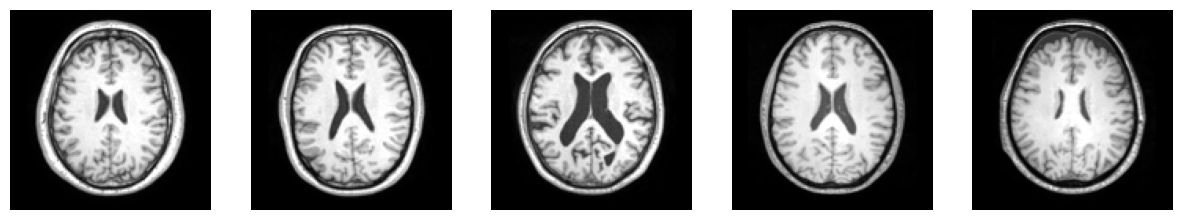

In [9]:
train_data_module_healthy = TrainDataModule(
    data_dir=config['train_data_healthy'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module_healthy.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

### 1.2. Load and visualize the *pathology* data (Stroke)

Found 300 files in ./brain/atlas/test
Using 240 images for training and 60 images for validation
Batch shape: torch.Size([32, 1, 128, 128])
Batch min: 0.0
Batch max: 1.0


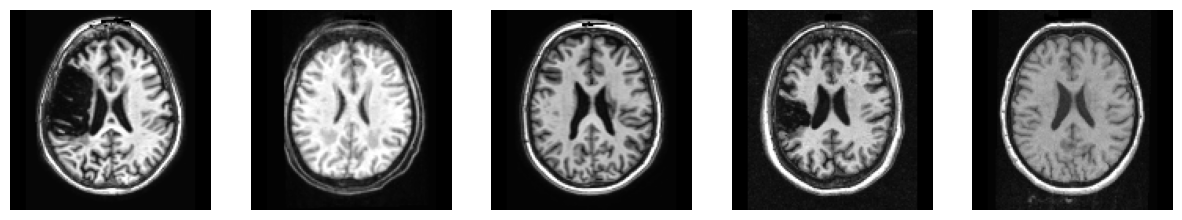

In [10]:
train_data_module_stroke = TrainDataModule(
    data_dir=config['train_data_stroke'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module_stroke.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## 2. Understanding VAEs
**Variational Autoencoders (VAEs)** consist of:
- An **encoder** that maps input images to a latent space.
- A **decoder** that reconstructs images from the latent space.

They are trained to minimize:
- The **reconstruction error**.
- The **Kullback-Leibler (KL) divergence** between the learned latent distribution and a prior distribution.

#### Why VAEs?
VAEs are useful for:
- **Image synthesis**: Generating new images similar to the training data.
- **Anomaly detection**: Identifying unusual patterns by reconstructing normal images.

#### Key Concepts
- **Latent space**: A compressed representation of input data.
- **KL divergence**: A measure of how one probability distribution differs from a second, expected probability distribution.



### [10 points] ----------------------------------------- T1 (VAE) -----------------------------------------
Implement the missing lines marked by `[TODO]` in **model/vae.py**

In [12]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [28]:
from model.vae import VAELightning
# Initialize the VAE model
input_dim = config['target_size']  # Example input dimensions
latent_dim = config['latent_dim']
num_epochs = config['num_epochs']

vae_model_healthy = VAELightning([1,input_dim[0],input_dim[1]], latent_dim)
vae_model_stroke = VAELightning([1,input_dim[0],input_dim[1]], latent_dim)

# Set up the trainer

# Check if MPS is available
accelerator = "mps" if pl.accelerators.MPSAccelerator.is_available() else "cpu"

# Create trainers with the conditional accelerator
trainer_healthy = pl.Trainer(max_epochs=num_epochs, accelerator=accelerator, devices=1)
trainer_stroke = pl.Trainer(max_epochs=num_epochs, accelerator=accelerator, devices=1)


# Start training
trainer_healthy.fit(vae_model_healthy, train_data_module_healthy.train_dataloader(), train_data_module_healthy.val_dataloader())
trainer_stroke.fit(vae_model_stroke, train_data_module_stroke.train_dataloader(), train_data_module_stroke.val_dataloader())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/dani/opt/anaconda3/envs/mps_ai_med/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 320    | train
1  | conv2     | Conv2d          | 18.5 K | train
2  | conv3     | Conv2d          | 73.9 K | train
3  | fc1       | Linear          | 8.4 M  | train
4  | fc_mu     | Linear          | 16.4 K | train
5  | fc_logvar | Linear          | 16.4 K | train
6  | fc2       | Linear          | 16.6 K | train
7  | fc3       | Linear          | 8.4 M  | train
8  | conv4     | ConvTranspose2d | 73.8 K | train
9  

Epoch 5:  87%|████████▋ | 13/15 [00:00<00:00, 15.68it/s, v_num=4]

/Users/dani/opt/anaconda3/envs/mps_ai_med/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 320    | train
1  | conv2     | Conv2d          | 18.5 K | train
2  | conv3     | Conv2d          | 73.9 K | train
3  | fc1       | Linear          | 8.4 M  | train
4  | fc_mu     | Linear          | 16.4 K | train
5  | fc_logvar | Linear          | 16.4 K | train
6  | fc2       | Linear          | 16.6 K | train
7  | fc3       | Linear          | 8.4 M  | train
8  | conv4     | ConvTranspose2d | 73.8 K | train
9  | conv5     | ConvTranspose2d | 18.5 K | train
10 | conv6     | ConvTranspose2d | 289    | train
-------------------------------------------------------
17.0 M    Trainable params
0         Non-trainable params
17.0 M    Total params
68.180    Total estimated model params

Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 16.23it/s, v_num=5]

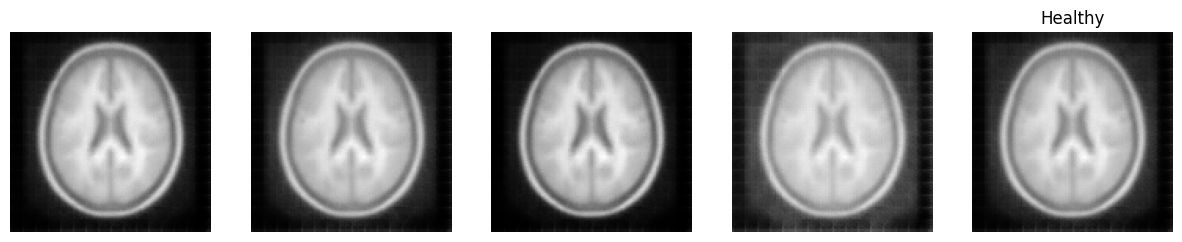

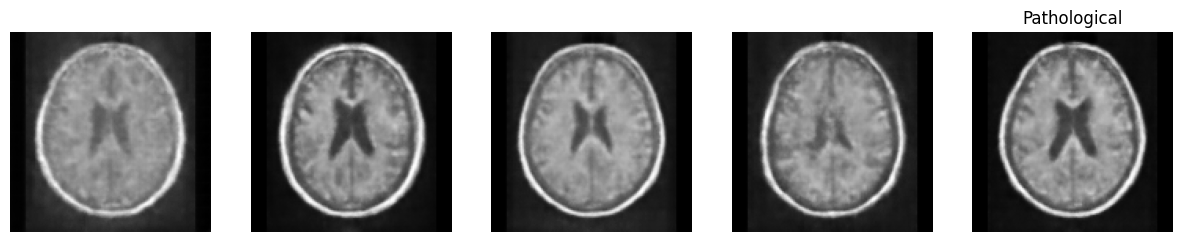

In [15]:
# Generate random samples
vae_model_healthy.eval()
vae_model_stroke.eval()

# Enable MPS device if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

with torch.no_grad():  # Context manager that disables gradient calculations
    # Ensure your VAE models are on the MPS device
    vae_model_healthy = vae_model_healthy.to(device)
    vae_model_stroke = vae_model_stroke.to(device)
    
    # Generate random latent vectors and decode them using the VAE model for healthy samples
    random_healthy_samples = vae_model_healthy.decode(
        torch.randn(16, latent_dim, device=device)
    ).to('cpu').numpy()  # Transfer to CPU after the computation
    
    # Generate random latent vectors and decode them using the VAE model for stroke samples
    random_stroke_samples = vae_model_stroke.decode(
        torch.randn(16, latent_dim, device=device)
    ).to('cpu').numpy()  # Transfer to CPU after the computation

# with torch.no_grad():
#     random_healthy_samples = vae_model_healthy.decode(torch.randn(16, latent_dim)).cpu().numpy()
#     random_stroke_samples = vae_model_stroke.decode(torch.randn(16, latent_dim)).cpu().numpy()

# Plot the random samples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Healthy')
for i in range(5):
    ax[i].imshow(random_healthy_samples[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Pathological')
for i in range(5):
    ax[i].imshow(random_stroke_samples[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q1 (VAE) -----------------------------------------
Describe the quality of the generated images from the VAE model. Are there any noticeable differences between the healthy and pathological (stroke lesion) cases? Provide possible reasons for the observed similarities or differences.

### [10 points] ----------------------------------------- Q2 (VAE) -----------------------------------------
Suggest potential ways to improve the quality and diversity of the generated images, particularly for the pathological cases.

## 3. Understanding GANs

*Generative Adversarial Networks (GANs)* consist of:

- **A Generator:** This network generates new data instances that resemble the training data.
- **A Discriminator:** This network evaluates the authenticity of the generated data, distinguishing between real and fake data.

They are trained to minimize:
- The Generator's loss: Encourages the generator to produce data that the *discriminator cannot distinguish* from real data.
- The Discriminator's loss: Encourages the discriminator to accurately *classify real and fake* data.

**Why GANs?**
GANs are useful for:
- **Image synthesis:** Creating realistic images that are indistinguishable from real images.
- **Data augmentation:** Generating additional training data to improve the performance of machine learning models.
- **Style transfer:** Applying the style of one image to the content of another.

**Key Concepts**
- **Adversarial training:** A training process where the generator and discriminator compete against each other, improving their performance iteratively.
- **Latent space:** A compressed representation from which the generator creates new data instances.
- **Mode collapse:** A common issue where the generator produces limited varieties of outputs, failing to capture the diversity of the training data.


In [17]:
from model.wgan import GANModule
# Initialize the GAN model
hparams = {
    'image_size': input_dim[1],
    'latent_dim': latent_dim,
    'channels': 1,
    'lr': 0.0002,
    'n_critic': 1
}
gan_model = GANModule(hparams)

# Set up the trainer
# Check if MPS is available
accelerator = "mps" if pl.accelerators.MPSAccelerator.is_available() else "cpu"

# Create trainer with the conditional accelerator
trainer = pl.Trainer(max_epochs=num_epochs,  accelerator=accelerator, devices=1)  # Adjust trainer parameters as needed

# Start training
trainer.fit(gan_model, train_data_module_healthy.train_dataloader(), train_data_module_healthy.val_dataloader())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | WGAN | 8.8 M  | train
---------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.392    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s, v_num=3, d_loss_step=3.890, g_loss_step=-9.66, d_loss_epoch=0.160, g_loss_epoch=-8.99]     

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s, v_num=3, d_loss_step=3.890, g_loss_step=-9.66, d_loss_epoch=0.160, g_loss_epoch=-8.99]


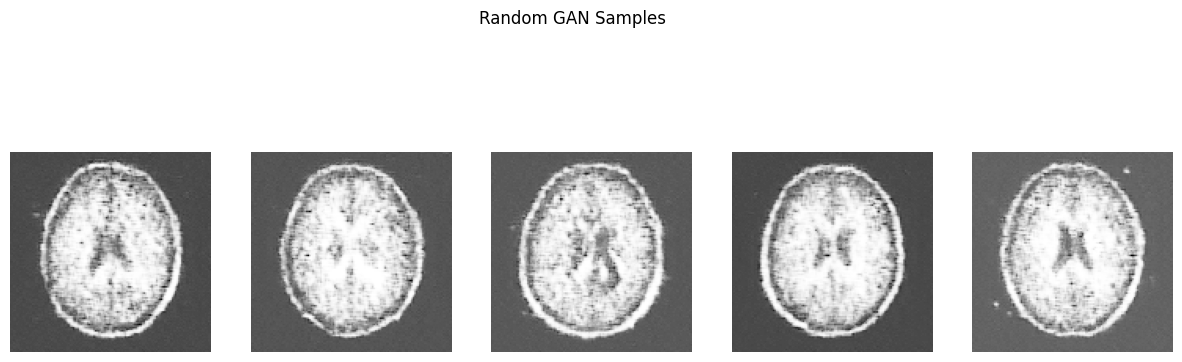

In [18]:
# Generate random samples
gan_model.eval()
with torch.no_grad():
    random_samples = gan_model(torch.randn(16, latent_dim)).cpu().numpy()

# Plot the random samples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random GAN Samples')
for i in range(5):
    sample_img = random_samples[i]
    ax[i].imshow(np.squeeze(sample_img), cmap='gray')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q3 (GAN) -----------------------------------------
Describe the quality of the generated brain MRI images from the GAN model. How do they compare to the real images in terms of realism and diversity? How do they compare to VAEs?

### [5 points] ----------------------------------------- Q4 (GAN) -----------------------------------------
 How can me measure the quality of the reconstruction for GANs? Implement a metric and compare the similarity to the pathological and healthy test sets.

### [15 points] ----------------------------------------- T2 (GAN) -----------------------------------------
Implement a metric and compare the similarity to the pathological and healthy test sets. (Hint: The metric should evaluate the closeness of two distributions)

In [27]:
import torch
import torchvision.models as models
from scipy.linalg import sqrtm
import numpy as np

# Function to calculate the activations of images using an MPS-enabled device
def calculate_activations(images, model, device):
    model.eval()
    with torch.no_grad():
        # Ensure images are on the correct device
        activations = model(images.to(device))
    return activations.cpu().detach().numpy()

# Function to calculate Frechet Distance
def calculate_fid(real_activations, fake_activations):
    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0]
    # Handle complex numbers that might arise in sqrtm computation
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Check if MPS is available and set the device appropriately
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load and modify the Inception v3 model for feature extraction
inception_v3 = models.inception_v3(pretrained=True, transform_input=False)
inception_v3.fc = torch.nn.Identity()  # Adapt the model to output activations from the last layer
inception_v3 = inception_v3.to(device)

# Loading data
healthy_loader = train_data_module_healthy.val_dataloader()
pathological_loader = train_data_module_stroke.val_dataloader()

# Calculate activations for both datasets

# Function to convert 1-channel images to 3-channel images by repeating the channel
def to_rgb(image):
    return image.repeat(1, 3, 1, 1)  # Repeat the channel dimension (channel is at index 1)

# Adjusted processing loop
healthy_activations = []
for batch in healthy_loader:
    # Convert the batch to 3-channel
    batch_rgb = to_rgb(batch.to(device))
    activations = calculate_activations(batch_rgb, inception_v3, device)
    healthy_activations.append(activations)

# Concatenate all activations
healthy_activations = np.concatenate(healthy_activations)

pathological_activations = []
for batch in pathological_loader:
    # Convert the batch to 3-channel
    batch_rgb = to_rgb(batch.to(device))
    activations = calculate_activations(batch_rgb, inception_v3, device)
    pathological_activations.append(activations)

# Concatenate all activations
pathological_activations = np.concatenate(pathological_activations)

# Calculate the FID score
fid_score = calculate_fid(healthy_activations, pathological_activations)
print("FID score:", fid_score)

/Users/dani/opt/anaconda3/envs/mps_ai_med/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dani/opt/anaconda3/envs/mps_ai_med/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 726.7161557934534


## 4. Understanding Diffusion Models

**Why Diffusion Models?**
Diffusion Models are useful for:
- **Image synthesis:** Generating new images that resemble the training data.
- **Image denoising:** Removing noise from images to restore their original quality.
- **Inpainting and super-resolution:** Filling in missing parts of images and enhancing image resolution.
- **Anomaly Detection:** Generating pseudo-normal samples by *partly* noising and denoising pathological images.

**Key Concepts**

- **Forward and Reverse Processes:** The forward process adds noise to the data, while the reverse process removes it.
- **Markov chain:** A sequence of steps where each step depends only on the previous one, used in both the forward and reverse processes.
- **Noise schedule:** A predefined sequence of noise levels added during the forward process, which the model learns to reverse.

Diffusion models are powerful generative models that have shown significant promise in various applications.



**Get trained model** (DDPM with Gaussian noise trained for 1500 epochs on healthy samples)

In [ ]:
!wget https://syncandshare.lrz.de/dl/fiGC15qSsdj1Tx7uojZvAT/latest_model.pt.zip # weights
!unzip -q latest_model.pt.zip

### Load weights

In [ ]:
with open('./configs/diffusion_config.yaml', 'r') as f:
    diff_config = yaml.safe_load(f)

In [ ]:
!pip install monai

In [ ]:
from model.ddpm import DDPM

In [ ]:
diff_config

In [ ]:
#diff_config
anoddpm = DDPM(**diff_config)
anoddpm.to('cuda:0')

In [ ]:
print(torch.cuda.device_count())

In [ ]:
# load weights
checkpoint = torch.load('latest_model.pt',map_location='cuda:0', weights_only=True)['model_weights']
anoddpm.load_state_dict(checkpoint)

In [ ]:
t=200
x_, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t)

In [ ]:
# Input

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Inputs')
for i in range(5):
    sample_img = batch[i]
    ax[i].imshow(sample_img[0], cmap='gray')
    ax[i].axis('off')
plt.show()

# Recons
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Reconstructions')
for i in range(5):
    sample_img = x_[i].cpu().numpy()
    ax[i].imshow(sample_img[0], cmap='gray')
    ax[i].axis('off')
plt.show()

# Anomaly maps
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Anomaly Maps')
for i in range(5):
    sample_img = np.abs(batch[i] - x_[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q5 (Diffusion) -----------------------------------------
How does the anomaly detection performance vary with varying noise levels t? (Hint: Visually analyse the performance for different noise levels **t** (one batch is enough))

### [10 points] ----------------------------------------- T3 (Diffusion) -----------------------------------------
Write a dataloader to load both images and ground truth masks in atlas/train/:

### [20 points] ----------------------------------------- T4 (Diffusion) -----------------------------------------
Evaluate the diffusion models on the atlas/train dataset on pixel-wise localization. Implement therefore the Dice Score and report the mean and std for the dataset. You would therefore need to select a noise level **t**. (motivate selection based on Q5).  

## 5. Bonus: Vision-Language Generative Models (VLMs)

VLMs consist of:
- **Image Encoder:** Transforms images into a latent representation.
- **Text Encoder:** Converts text descriptions into a corresponding latent representation.
- **Multimodal Fusion Module:** Aligns and integrates the visual and textual representations.
- **Text Decoder:** Generates text outputs based on the fused multimodal representation.

They are trained to minimize:
- **Cross-Modal Matching Loss:** Ensures that the visual and textual representations are aligned in the latent space.
- **Generation Loss:** Measures the accuracy of the generated text or image against the ground truth.

**Why Vision-Language Generative Models?**

*Applications and Challenges*
Vision-Language Generative Models have numerous applications, including creating visual content from text prompts, enhancing human-computer interaction through visual assistants, and improving accessibility with automatic image descriptions. However, challenges such as understanding spatial relationships, handling high-dimensional visual data, and ensuring the reliability of generated content remain active areas of research.

### [10 points] ----------------------------------------- Q6 (VLMs) -----------------------------------------
**Outline** how Vision-Language Generative Models can be used to generate samples. Consider the following aspects:

- *Training Process:* Describe the steps involved in training a VLG model, including data preparation, model architecture, and loss functions.
- *Generation Process:* Explain how the model generates new samples, whether text from images or images from text.
- *Applications:* Discuss potential applications of VLG models in real-world scenarios, such as automated content creation, visual question answering, and accessibility enhancements.
- *Challenges:* Identify and elaborate on the key challenges faced in developing and deploying VLG models, such as handling high-dimensional data and ensuring the accuracy and relevance of generated content.